In [13]:
# Importing the right base libraries
import os
# Remove GPU use
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("../../")

import numpy as np

In [14]:
from choice_learn.datasets import load_tafeng

tafeng_df = load_tafeng(as_frame=True)
tafeng_df.head()

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,11/1/2000,1104905,45-49,115,110411,4710199010372,2,24,30
1,11/1/2000,418683,45-49,115,120107,4710857472535,1,48,46
2,11/1/2000,1057331,35-39,115,100407,4710043654103,2,142,166
3,11/1/2000,1849332,45-49,Others,120108,4710126092129,1,32,38
4,11/1/2000,1981995,50-54,115,100205,4710176021445,1,14,18


In [15]:
tafeng_df = tafeng_df.loc[tafeng_df.PRODUCT_ID.isin(tafeng_df.PRODUCT_ID.value_counts().index[:20])].reset_index(drop=True)
tafeng_df = tafeng_df.loc[tafeng_df.AGE_GROUP.isin(['25-29', '40-44', '45-49', '>65', '30-34', '35-39', '50-54',
       '55-59', '60-64'])].reset_index(drop=True)
tafeng_df

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,11/1/2000,1187366,25-29,221,130315,4714981010038,2,56,48
1,11/1/2000,630849,40-44,115,130315,4714981010038,2,56,48
2,11/1/2000,217361,45-49,115,120103,4710011401128,2,46,56
3,11/1/2000,305167,>65,115,110217,4719090900058,1,145,149
4,11/1/2000,760225,30-34,115,110106,4711271000014,1,14,16
...,...,...,...,...,...,...,...,...,...
43131,2/28/2001,40150,45-49,115,130315,4714981010038,2,50,26
43132,2/28/2001,697590,45-49,115,500201,4712425010712,1,121,129
43133,2/28/2001,199599,40-44,115,110217,4719090900065,2,300,274
43134,2/28/2001,821315,40-44,114,130315,4714981010038,1,25,13


In [16]:
tafeng_df["twenties"] = tafeng_df.apply(lambda row: 1 if row["AGE_GROUP"] == "25-29" else 0, axis=1)
tafeng_df["thirties"] = tafeng_df.apply(lambda row: 1 if row["AGE_GROUP"] in (["30-34", "35-39"]) else 0, axis=1)
tafeng_df["forties"] = tafeng_df.apply(lambda row: 1 if row["AGE_GROUP"] in (["40-44", "45-49"]) else 0, axis=1)
tafeng_df["fifties"] = tafeng_df.apply(lambda row: 1 if row["AGE_GROUP"] in (["50-54", "55-59"]) else 0, axis=1)
tafeng_df["sixties+"] = tafeng_df.apply(lambda row: 1 if row["AGE_GROUP"] in (["60-64", ">65"]) else 0, axis=1)

In [17]:
# product ID to index
id_to_index = {}
for i, product_id in enumerate(np.sort(tafeng_df.PRODUCT_ID.unique())):
    id_to_index[product_id] = i

prices = [[0] for _ in range(len(id_to_index))]
for k, v in id_to_index.items():
    prices[v][0] = tafeng_df.loc[tafeng_df.PRODUCT_ID == k].SALES_PRICE.to_numpy()[0]

# Create the arrays that will constitute the ChoiceDataset

shared_features = []
items_features = []
choices = []

for i, row in tafeng_df.iterrows():
    item_index = id_to_index[row.PRODUCT_ID]
    prices[item_index][0] = row.SALES_PRICE
    shared_features.append(row[['twenties', 'thirties', 'forties', 'fifties', 'sixties+']].to_numpy())
    items_features.append(prices)
    choices.append(item_index)

In [18]:
from choice_learn.data import ChoiceDataset

dataset = ChoiceDataset(
    shared_features_by_choice=shared_features,
    shared_features_by_choice_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties+'],
    items_features_by_choice=items_features,
    items_features_by_choice_names=["SALES_PRICE"],
    choices=choices
)

In [19]:
from choice_learn.models import ConditionalLogit

model = ConditionalLogit(optimizer="Adam", batch_size=1024, epochs=500, lr=0.002)

for age_category in ['twenties', 'thirties', 'forties', 'fifties', 'sixties+']:
    model.add_coefficients(coefficient_name=age_category,
    feature_name=age_category,
    items_indexes=list(range(20)))

model.add_shared_coefficient(coefficient_name="price", feature_name="SALES_PRICE", items_indexes=list(range(20)))

hist = model.fit(dataset)

Epoch 499 Train Loss 2.7909: 100%|██████████| 500/500 [02:18<00:00,  3.60it/s]


Text(0, 0.5, 'Negative Log Likelihood')

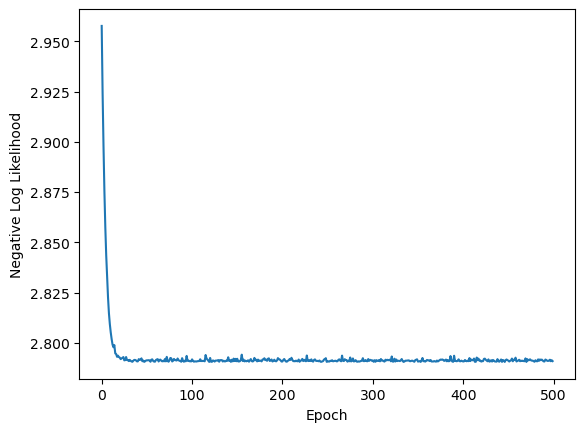

In [20]:
import matplotlib.pyplot as plt

plt.plot(hist["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")

In [21]:
future_prices = np.stack([items_features[-1]]*5, axis=0)
age_category = np.eye(5).astype("float32")
predicted_utilities = model.compute_batch_utility(shared_features_by_choice=age_category,
                                                  items_features_by_choice=future_prices,
                                                  available_items_by_choice=np.ones((5, 20)),
                                                  choices=None
                                                  )

age_category_weights = np.sum(shared_features, axis=0) / len(shared_features)

In [22]:
from choice_learn.toolbox.assortment_optimizer import LatentClassAssortmentOptimizer

opt = LatentClassAssortmentOptimizer(
    solver="or-tools", # Solver to use, either "or-tools" or "gurobi"
    class_weights=age_category_weights, # Weights of each class
    class_utilities=np.exp(predicted_utilities), # utilities in the shape (n_classes, n_items)
    itemwise_values=future_prices[0][:, 0], # Values to optimize for each item, here price that is used to compute turnover
    assortment_size=12) # Size of the assortment we want

assortment, opt_obj = opt.solve()

In [23]:
print("Our Optimal Assortment is:")
print(assortment)
print("With an estimated average revenue of:", opt_obj)
print("Size of our assortment:", np.sum((assortment > 0)), "which is fine with our limit of 12!")

Our Optimal Assortment is:
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
With an estimated average revenue of: 141.5864957073263
Size of our assortment: 5 which is fine with our limit of 12!
